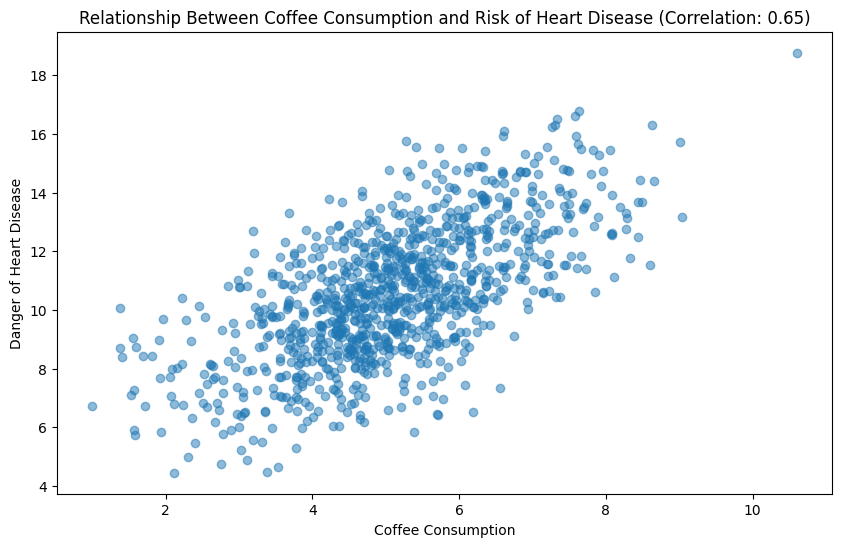

Correlation coefficient between coffee consumption and risk of heart disease: 0.65


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Data
np.random.seed(42)
age = np.random.normal(50, 10, 1000)
coffee_consumption = age * 0.1 + np.random.normal(0, 1, 1000)
heart_disease_risk = age * 0.2 + coffee_consumption * 0.1 + np.random.normal(0, 1, 1000)

# Correlation
corr_coffee_heart, _ = stats.pearsonr(coffee_consumption, heart_disease_risk)

# Graph
plt.figure(figsize=(10, 6))
plt.scatter(coffee_consumption, heart_disease_risk, alpha=0.5)
plt.title(f'Relationship Between Coffee Consumption and Risk of Heart Disease (Correlation: {corr_coffee_heart:.2f})')
plt.xlabel('Coffee Consumption')
plt.ylabel('Danger of Heart Disease')
plt.savefig("scatter-plot.png", dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Correlation coefficient between coffee consumption and risk of heart disease: {corr_coffee_heart:.2f}")

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Propensity Score
X = age.reshape(-1, 1)
treatment = (coffee_consumption > np.median(coffee_consumption)).astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

propensity_model = LogisticRegression()
propensity_model.fit(X_scaled, treatment)

propensity_scores = propensity_model.predict_proba(X_scaled)[:, 1]

# Propensity Score Matching (간단한 예시)
def match_propensity(prop_scores, treatment, outcome, caliper=0.2):
    treated = np.where(treatment == 1)[0]
    control = np.where(treatment == 0)[0]
    matches = []
    
    for t in treated:
        best_match = None
        min_diff = float('inf')
        for c in control:
            diff = abs(prop_scores[t] - prop_scores[c])
            if diff < min_diff and diff < caliper:
                best_match = c
                min_diff = diff
        if best_match is not None:
            matches.append((t, best_match))
    
    return matches

matches = match_propensity(propensity_scores, treatment, heart_disease_risk)

# Results
treated_outcomes = [heart_disease_risk[m[0]] for m in matches]
control_outcomes = [heart_disease_risk[m[1]] for m in matches]

effect = np.mean(treated_outcomes) - np.mean(control_outcomes)
print(f"Estimated Treatment Effect: {effect:.2f}")

Estimated Treatment Effect: 0.20


In [3]:
# 역확률 가중치 계산
def calculate_ipw(propensity_scores, treatment):
    ipw = treatment / propensity_scores + (1 - treatment) / (1 - propensity_scores)
    return ipw

ipw = calculate_ipw(propensity_scores, treatment)

# 가중 평균 처치 효과 계산
weighted_effect = np.sum(ipw * treatment * heart_disease_risk) / np.sum(ipw * treatment) - \
                  np.sum(ipw * (1 - treatment) * heart_disease_risk) / np.sum(ipw * (1 - treatment))

print(f"Estimated treatment effect via IPW: {weighted_effect:.2f}")

Estimated treatment effect via IPW: 0.53


In [4]:
from sklearn.linear_model import LinearRegression

# 가상의 도구 변수 생성 (예: 커피 가격)
coffee_price = age * -0.05 + np.random.normal(0, 1, 1000)

# 2단계 최소제곱법 (2SLS) 구현
stage1 = LinearRegression().fit(coffee_price.reshape(-1, 1), coffee_consumption)
predicted_consumption = stage1.predict(coffee_price.reshape(-1, 1))

stage2 = LinearRegression().fit(predicted_consumption.reshape(-1, 1), heart_disease_risk)

iv_effect = stage2.coef_[0]
print(f"Estimated treatment effect via Instrumental Variable: {iv_effect:.2f}")

Estimated treatment effect via Instrumental Variable: 1.94


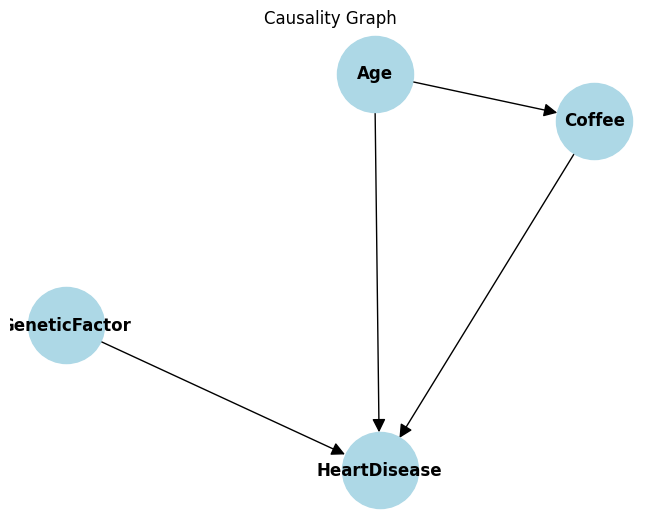

In [5]:
import networkx as nx

# 인과 그래프 생성
G = nx.DiGraph()
G.add_edges_from([('Age', 'Coffee'), ('Age', 'HeartDisease'), 
                  ('Coffee', 'HeartDisease'), ('GeneticFactor', 'HeartDisease')])

# 그래프 시각화
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, arrowsize=20, font_size=12, font_weight='bold')

plt.title("Causality Graph")
plt.show()

In [6]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 다중 처치 시나리오 (커피 + 운동)
exercise = np.random.choice([0, 1, 2], size=1000)  # 0: none, 1: rarely, 2: often
heart_disease_risk = age * 0.2 + coffee_consumption * 0.1 - exercise * 0.5 + np.random.normal(0, 1, 1000)

# ANOVA와 사후 분석
df = pd.DataFrame({'Exercise': exercise, 'HeartRisk': heart_disease_risk})
tukey_results = pairwise_tukeyhsd(df['HeartRisk'], df['Exercise'])
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -0.546 0.0071 -0.9692 -0.1228   True
     0      2  -1.1272    0.0 -1.5533 -0.7011   True
     1      2  -0.5812  0.004 -1.0067 -0.1558   True
----------------------------------------------------
